# Combination Food detection and Food Classification Model

In [2]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import os

In [8]:
# ================== PATHS (EDIT THESE) ==================
ROOT = Path(r"C:/Users/User/PycharmProjects/PythonProject/FYP/FoodWasteEstimator")

# Detection Model and Classification Path
DET_MODEL_PATH = ROOT / r"DetectFood/UECFOOD100_det/weights/best.pt"   # detector
CLS_MODEL_PATH = ROOT / r"food-101\food101_yolo\Result_CLS_Neck\runs_N_star_CA_100\weights\best.pt"  # <-- EDIT to your cls best.pt

# Input and Output Food Waste File
IMG_DIR  = ROOT / r"DetectFood"          # folder with test images (test1.jpg, etc.)
SAVE_DIR = ROOT / r"DetectFood/FoodWaste_Recognise"  # new folder for pipeline outputs
CROP_DIR = ROOT / r"MiDaS\input"

os.makedirs(SAVE_DIR, exist_ok=True)

In [9]:
# ================== LOAD MODELS ==================
det_model = YOLO(str(DET_MODEL_PATH))  # one-class detector
cls_model = YOLO(str(CLS_MODEL_PATH))  # Food-101 classifier (YOLOv8-cls)


Processing: test1.jpg
  saved annotated image -> test1_det_cls.jpg
  box (104, 207, 957, 556)  det_conf=0.46  class=fried_rice (0.18)


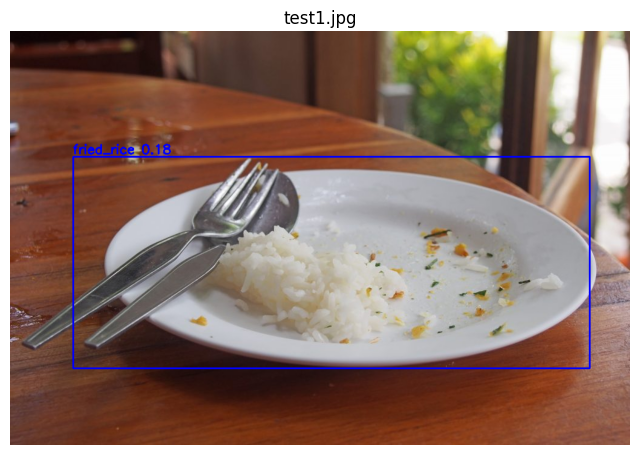

  saved bbox json -> test1_det_cls.json

Processing: test10.jpg
  saved annotated image -> test10_det_cls.jpg
  box (796, 143, 1057, 504)  det_conf=0.16  class=cannoli (0.27)
  box (581, 159, 831, 528)  det_conf=0.16  class=filet_mignon (0.17)


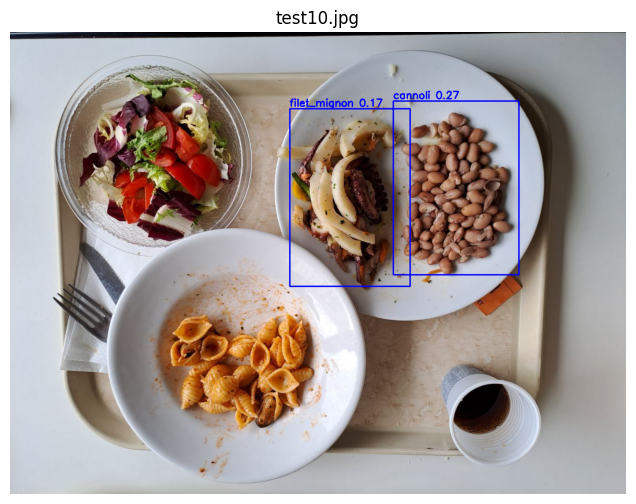

  saved bbox json -> test10_det_cls.json

Processing: test11.jpg
  saved annotated image -> test11_det_cls.jpg
  box (82, 0, 534, 255)  det_conf=0.31  class=fried_rice (0.98)


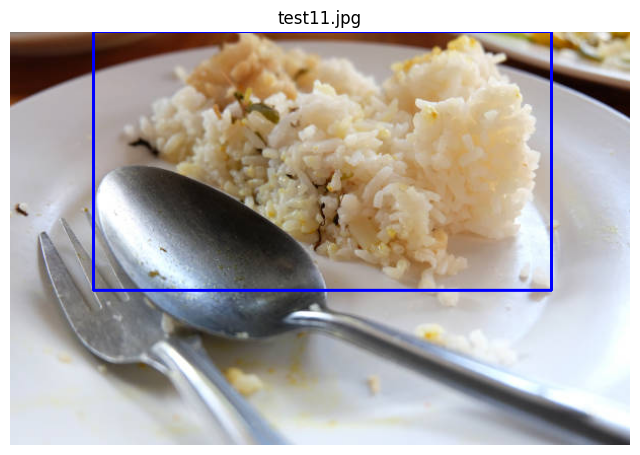

  saved bbox json -> test11_det_cls.json

Processing: test12.jpg
  saved annotated image -> test12_det_cls.jpg
  box (34, 52, 999, 1024)  det_conf=0.68  class=hummus (0.12)
  box (299, 167, 780, 680)  det_conf=0.26  class=risotto (0.20)


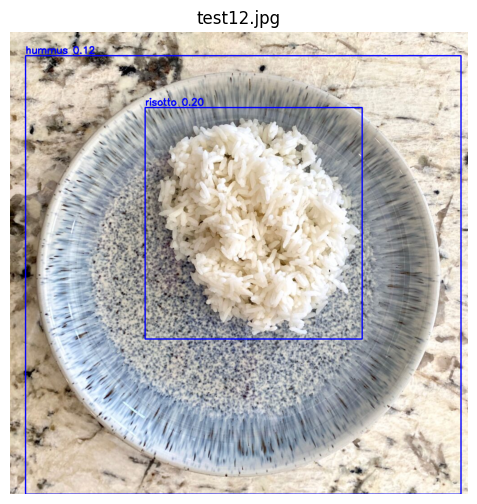

  saved bbox json -> test12_det_cls.json

Processing: test2.jpg
  saved annotated image -> test2_det_cls.jpg
  box (0, 0, 1024, 767)  det_conf=0.63  class=paella (0.22)


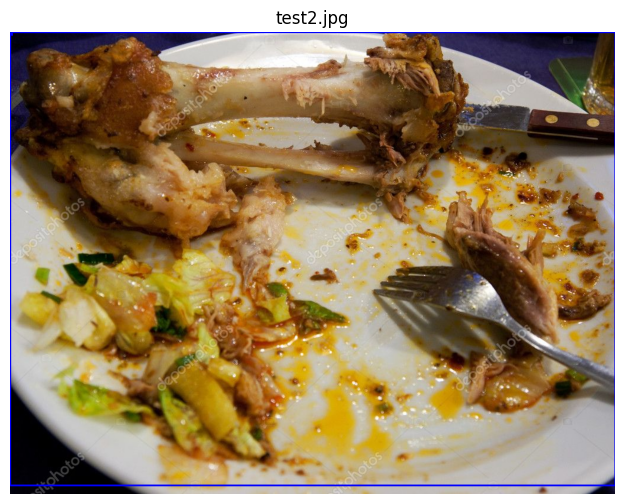

  saved bbox json -> test2_det_cls.json

Processing: test3.jpg
  saved annotated image -> test3_det_cls.jpg
  box (25, 91, 502, 973)  det_conf=0.16  class=clam_chowder (0.22)


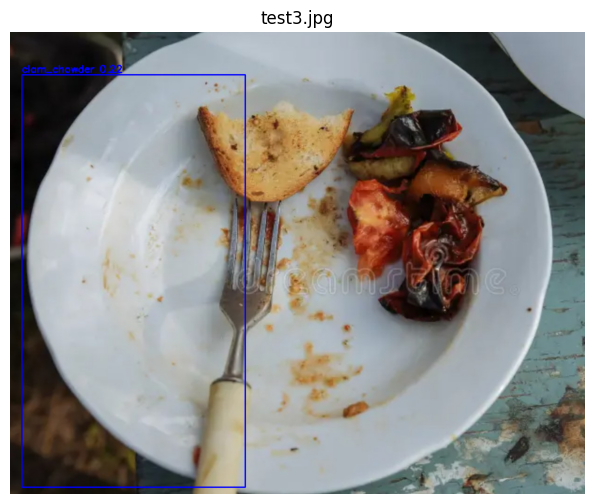

  saved bbox json -> test3_det_cls.json

Processing: test4.jpg
  saved annotated image -> test4_det_cls.jpg
  box (1180, 433, 1937, 914)  det_conf=0.23  class=macaroni_and_cheese (0.34)
  box (42, 136, 735, 491)  det_conf=0.15  class=spaghetti_carbonara (0.51)


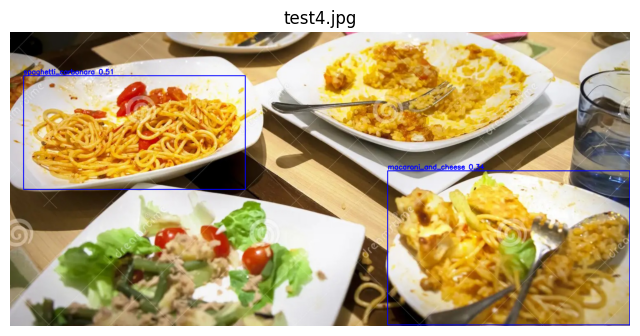

  saved bbox json -> test4_det_cls.json

Processing: test5.jpg
  saved annotated image -> test5_det_cls.jpg
  box (1, 0, 1129, 659)  det_conf=0.93  class=fried_rice (1.00)


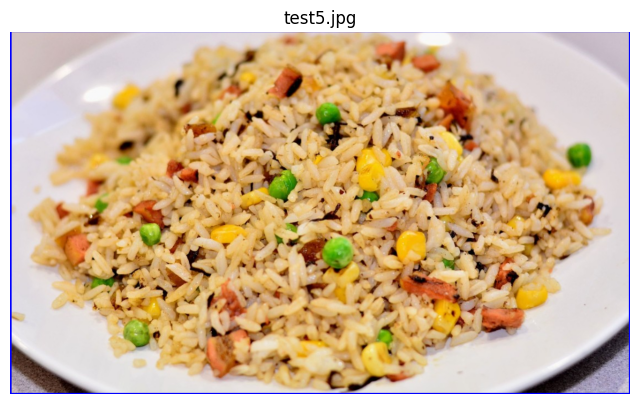

  saved bbox json -> test5_det_cls.json

Processing: test6.jpg
  (no food detected)

Processing: test7.jpg
  saved annotated image -> test7_det_cls.jpg
  box (40, 525, 343, 893)  det_conf=0.15  class=grilled_cheese_sandwich (0.28)


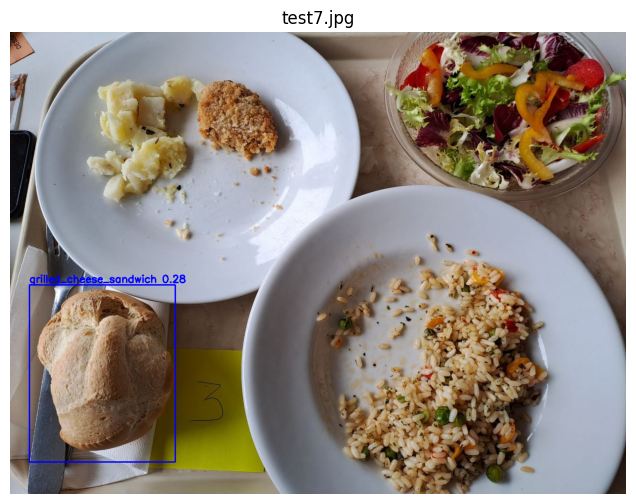

  saved bbox json -> test7_det_cls.json

Processing: test8.jpg
  (no food detected)

Processing: test9.jpg
  saved annotated image -> test9_det_cls.jpg
  box (154, 10, 697, 547)  det_conf=0.23  class=clam_chowder (0.97)


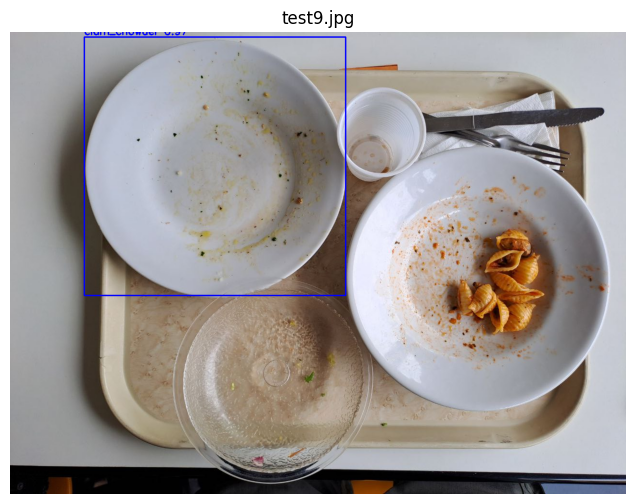

  saved bbox json -> test9_det_cls.json


In [57]:
# ================== HELPER FUNCTIONS ==================
def pad_crop(img, x1, y1, x2, y2, pad_ratio=0.05):
    """Crop with small padding around box."""
    h, w = img.shape[:2]
    pw = int((x2 - x1) * pad_ratio)
    ph = int((y2 - y1) * pad_ratio)
    x1 = max(0, x1 - pw)
    y1 = max(0, y1 - ph)
    x2 = min(w, x2 + pw)
    y2 = min(h, y2 + ph)
    return img[y1:y2, x1:x2]


def detect_and_classify_image(img_path, show=True):
    img_path = Path(img_path)
    print(f"\nProcessing: {img_path.name}")

    # --------- read original image ----------
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print("  !! could not read image")
        return
    h, w = img_bgr.shape[:2]

    # --------- 1) DETECTION ----------
    det_result = det_model.predict(
        source=img_bgr,
        imgsz=640,
        conf=0.15,           # detection threshold (tune 0.15–0.35)
        iou=0.5,
        verbose=False
    )[0]

    if det_result.boxes is None or len(det_result.boxes) == 0:
        print("  (no food detected)")
        return

    annotated = img_bgr.copy()
    records = []

    # --------- 2) LOOP OVER BOXES ----------
    for idx, box in enumerate(det_result.boxes):
        conf_det = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # ignore tiny boxes (usually noise)
        if (x2 - x1) * (y2 - y1) < 32 * 32:
            continue

        # crop around food region
        crop = pad_crop(img_bgr, x1, y1, x2, y2, pad_ratio=0.05)

        # --------- 3) CLASSIFICATION ----------
        cls_res = cls_model.predict(
            source=crop,
            imgsz=224,
            verbose=False
        )[0]

        top1_id   = int(cls_res.probs.top1)
        top1_conf = float(cls_res.probs.top1conf)
        label     = cls_res.names[top1_id]

        # store record (for debugging/logging)
        records.append({
            "bbox": (x1, y1, x2, y2),
            "det_conf": conf_det,
            "cls_label": label,
            "cls_conf": top1_conf
        })

        # --------- 4) DRAW ON ORIGINAL IMAGE ----------
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)
        text = f"{label} {top1_conf:.2f}"
        cv2.putText(
            annotated,
            text,
            (x1, max(y1 - 5, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 0, 0),
            2
        )

        # save individual crop to MiDas Folder (Calculate Depth Value)
        crop_name = f"{img_path.stem}_crop{idx+1}_{label}.jpg"
        cv2.imwrite(str(CROP_DIR / crop_name), crop)

        # save entire image to MiDas Folder
        entire_path = CROP_DIR / f"{img_path.stem}_det_cls.jpg"
        cv2.imwrite(str(entire_path), annotated)

    # --------- 5) SAVE & SHOW FINAL IMAGE ----------
    out_path = SAVE_DIR / f"{img_path.stem}_det_cls.jpg"
    cv2.imwrite(str(out_path), annotated)

    print(f"  saved annotated image -> {out_path.name}")
    for r in records:
        print(f"  box {r['bbox']}  det_conf={r['det_conf']:.2f}  "
              f"class={r['cls_label']} ({r['cls_conf']:.2f})")

    if show:
        img_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(img_path.name)
        plt.show()

    # --------- 5.5) SAVE BBOX RECORDS TO JSON ----------
    json_path = SAVE_DIR / f"{img_path.stem}_det_cls.json"
    payload = {
        "image": img_path.name,
        "image_w": int(w),
        "image_h": int(h),
        "records": [
            {
                "bbox": [int(r["bbox"][0]), int(r["bbox"][1]), int(r["bbox"][2]), int(r["bbox"][3])],
                "det_conf": float(r["det_conf"]),
                "cls_label": str(r["cls_label"]),
                "cls_conf": float(r["cls_conf"]),
            }
            for r in records
        ]
    }
    with open(json_path, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"  saved bbox json -> {json_path.name}")


# ================== RUN ON ALL TEST IMAGES ==================
for img_file in sorted(IMG_DIR.glob("test*.jpg")):
    detect_and_classify_image(img_file)


# MiDas Depth Estimation

In terminal:

Note: Make sure in MiDaS directory

RUN Command Below:

(My evironments only suggest this models version)

`python run.py --model_type dpt_large_384 --input_path input --output_path output`


(-0.5, 760.5, 388.5, -0.5)

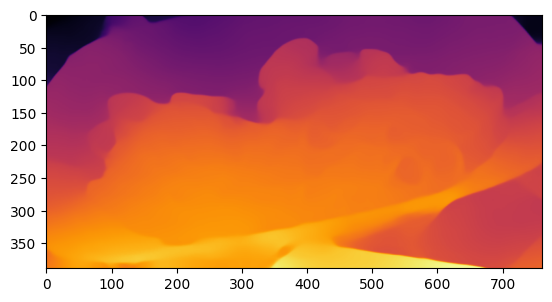

In [58]:
import cv2, matplotlib.pyplot as plt
img = cv2.imread("MiDas/output/test4_crop2_spaghetti_carbonara-dpt_large_384.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("on")

(-0.5, 760.5, 388.5, -0.5)

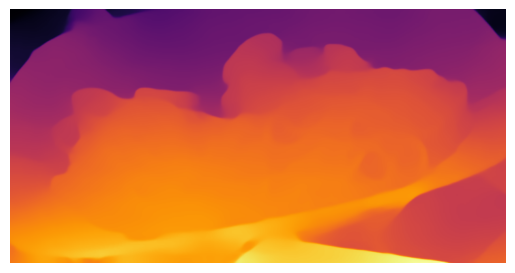

In [59]:
import cv2, matplotlib.pyplot as plt
img = cv2.imread("MiDas/output/test4_crop2_spaghetti_carbonara-dpt_large_384.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")

In [60]:
from MiDaS import utils  # the file that contains read_pfm/write_pfm
depth, scale = utils.read_pfm("MiDaS/output/test4_crop2_spaghetti_carbonara-dpt_large_384.pfm")
#print(depth.shape, depth.min(), depth.max(), depth.mean())
#print("depth shape:", depth.shape)
print("Minimum depth value:", depth.min())
print("Maximum depth value:", depth.max())
print("Average depth value:", depth.max())
print("center value:", depth[depth.shape[0]//2, depth.shape[1]//2])


Minimum depth value: 1.1909554
Maximum depth value: 34.187855
Average depth value: 34.187855
center value: 23.103836


# Food Waste Volume Estimation

## Imports + paths

In [1]:
import json
import cv2
import numpy as np
from pathlib import Path
from MiDaS import utils  # read_pfm


In [2]:
ROOT = Path(r"C:/Users/User/PycharmProjects/PythonProject/FYP/FoodWasteEstimator")



IMG_PATH  = ROOT / r"DetectFood/test4.jpg"
JSON_PATH = ROOT / r"DetectFood/FoodWaste_Recognise/test4_det_cls.json"
PFM_PATH  = ROOT / r"MiDaS\output\test4_det_cls-dpt_large_384.pfm"

print("IMG:", IMG_PATH)
print("JSON:", JSON_PATH)
print("PFM:", PFM_PATH)


IMG: C:\Users\User\PycharmProjects\PythonProject\FYP\FoodWasteEstimator\DetectFood\test4.jpg
JSON: C:\Users\User\PycharmProjects\PythonProject\FYP\FoodWasteEstimator\DetectFood\FoodWaste_Recognise\test4_det_cls.json
PFM: C:\Users\User\PycharmProjects\PythonProject\FYP\FoodWasteEstimator\MiDaS\output\test4_det_cls-dpt_large_384.pfm


## Load image + JSON + MiDaS depth (and RESIZE depth)

In [3]:
# 1) Load original image
img_bgr = cv2.imread(str(IMG_PATH))
assert img_bgr is not None, f"Cannot read image: {IMG_PATH}"
H, W = img_bgr.shape[:2]
print("Image shape (H, W):", (H, W))


# 2) Load detection results (bbox JSON)
data = json.loads(JSON_PATH.read_text())
records = data["records"]
print("Number of detected food items:", len(records))


# 3) Load MiDaS depth map (PFM)
depth, scale = utils.read_pfm(str(PFM_PATH))

print(
    "Raw depth= ", depth.shape,
    "| min = ", float(depth.min()),
    "| max = ", float(depth.max()),
    "| mean = ", float(depth.mean()),
)

# 4) Resize depth map to match image size (CRITICAL STEP)
depth_resized = cv2.resize(depth, (W, H), interpolation=cv2.INTER_CUBIC)

print(
    "Resized depth = ", depth_resized.shape,
    "| min =", float(depth_resized.min()),
    "| max =", float(depth_resized.max()),
    "| mean =", float(depth_resized.mean()),
)


Image shape (H, W): (918, 1938)
Number of detected food items: 2
Raw depth=  (918, 1938) | min =  2.038182020187378 | max =  36.9726448059082 | mean =  18.501991271972656
Resized depth =  (918, 1938) | min = 2.038182020187378 | max = 36.9726448059082 | mean = 18.501991271972656


## Load Mean depth of food waste in Detection

In [4]:
for r in records:
    x1, y1, x2, y2 = map(int, r["bbox"])
    crop = depth_resized[y1:y2, x1:x2]

    food_depth_mean = float(np.mean(crop))
    print(f"{r['cls_label']} | food_depth_mean = {food_depth_mean:.4f}")


macaroni_and_cheese | food_depth_mean = 28.2167
spaghetti_carbonara | food_depth_mean = 14.0599


## Relative volume (area_px * food_depth_mean)

In [5]:
def bbox_area_px(bbox):
    x1, y1, x2, y2 = map(int, bbox)
    return float(max(x2 - x1, 1) * max(y2 - y1, 1))

total_rel_vol = 0.0

for r in records:
    bbox = r["bbox"]
    x1, y1, x2, y2 = map(int, bbox)

    crop = depth_resized[y1:y2, x1:x2]
    food_depth_mean = float(np.mean(crop))

    area_px = bbox_area_px(bbox)
    rel_vol = area_px * food_depth_mean   # relative volume proxy

    total_rel_vol += rel_vol

    print(
        f"{r['cls_label']} | "
        f"area_px={area_px:.0f} | "
        f"food_depth_mean={food_depth_mean:.4f} | "
        f"relative_volume={rel_vol:.2f}"
    )

print("TOTAL relative volume:", total_rel_vol)


macaroni_and_cheese | area_px=364117 | food_depth_mean=28.2167 | relative_volume=10274175.15
spaghetti_carbonara | area_px=246015 | food_depth_mean=14.0599 | relative_volume=3458948.95
TOTAL relative volume: 13733124.0959692


# 6 Normalize depth

In [6]:
def normalize_depth_percentile(depth_map, p_low=5, p_high=95):
    lo = np.percentile(depth_map, p_low)
    hi = np.percentile(depth_map, p_high)
    d = np.clip(depth_map, lo, hi)
    d_norm = (d - lo) / (hi - lo + 1e-8)
    return d_norm

depth_norm = normalize_depth_percentile(depth_resized, p_low=5, p_high=95)

print(
    "Normalized depth:",
    depth_norm.shape,
    "min =", float(depth_norm.min()),
    "max =", float(depth_norm.max()),
    "mean =", float(depth_norm.mean())
)

Normalized depth: (918, 1938) min = 0.0 max = 1.0 mean = 0.493379682302475


# 7. Convert into CM

In [7]:
import cv2
import numpy as np

# ===== Load image =====
img_path = r"C:\Users\User\PycharmProjects\PythonProject\FYP\FoodWasteEstimator\plate.jpeg"   # <-- your plate image
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError("Could not load plate image")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (9, 9), 1.5)

# ===== Detect circular plate using Hough Circle Transform =====
circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=gray.shape[0] // 2,
    param1=100,
    param2=30,
    minRadius=int(gray.shape[0] * 0.3),
    maxRadius=int(gray.shape[0] * 0.5),
)

if circles is None:
    raise RuntimeError("Plate circle not detected")

# Take the largest detected circle
circles = np.uint16(np.around(circles))
x, y, radius_px = circles[0][0]

diameter_px = radius_px * 2

print(f"[INFO] Detected plate diameter: {diameter_px:.2f} pixels")


[INFO] Detected plate diameter: 922.00 pixels


In [9]:
# ===== Step 7A: Pixel -> cm (RELATIVE scaling) =====
# Uses automatically detected plate diameter (relative scale)

REF_OBJECT = "plate"
REF_LENGTH_CM = 20.0          # measure plate diameter (cm)
REF_LENGTH_PX = diameter_px  # auto-detected from image

CM_PER_PX = REF_LENGTH_CM / REF_LENGTH_PX

print(f"[INFO] Relative scale from {REF_OBJECT}:")
print(f"        1 px ≈ {CM_PER_PX:.6f} cm")

[INFO] Relative scale from plate:
        1 px ≈ 0.021692 cm


In [10]:
def bbox_area_cm2(bbox, cm_per_px, fill_factor=0.7):
    x1, y1, x2, y2 = map(int, bbox)
    area_px = max(x2 - x1, 1) * max(y2 - y1, 1)
    return area_px * (cm_per_px ** 2) * fill_factor


In [11]:
# ===== Step 7C: Volume estimation (relative volume index) =====

AREA_FILL_FACTOR = 0.7
total_volume = 0.0

for r in records:
    bbox = r["bbox"]
    x1, y1, x2, y2 = map(int, bbox)

    # depth crop from NORMALIZED depth map (unitless)
    crop_norm = depth_norm[y1:y2, x1:x2]
    food_depth_mean_norm = float(np.mean(crop_norm))  # single value

    # area in cm^2 (from bbox)
    area_cm2 = bbox_area_cm2(bbox, CM_PER_PX, AREA_FILL_FACTOR)

    # volume proxy (NOT cm^3)
    volume = area_cm2 * food_depth_mean_norm
    total_volume += volume

    print(
        f"Food waste: {r['cls_label']} | "
        f"area_cm2={area_cm2:.2f} | "
        f"depth_mean_norm={food_depth_mean_norm:.3f} | "
        f"volume_index={volume:.3f}"
    )

print("Total volume index:", total_volume)


Food waste: macaroni_and_cheese | area_cm2=119.93 | depth_mean_norm=0.816 | volume_index=97.903
Food waste: spaghetti_carbonara | area_cm2=81.03 | depth_mean_norm=0.343 | volume_index=27.769
Total volume index: 125.6721945395939


# Save outputs to CSV

In [12]:
import pandas as pd
import numpy as np

AREA_FILL_FACTOR = 0.7
rows = []

for r in records:
    bbox = r["bbox"]
    x1, y1, x2, y2 = map(int, bbox)

    # area in cm^2
    area_cm2 = bbox_area_cm2(bbox, CM_PER_PX, AREA_FILL_FACTOR)

    # mean normalized depth inside bbox (unitless)
    crop_norm = depth_norm[y1:y2, x1:x2]
    food_depth_mean_norm = float(np.mean(crop_norm)) if crop_norm.size else float("nan")

    # per-object volume proxy (unitless scale)
    volume_index = area_cm2 * food_depth_mean_norm

    rows.append({
        "image": IMG_PATH.name,
        "cls_label": r["cls_label"],
        "det_conf": r.get("det_conf"),
        "cls_conf": r.get("cls_conf"),
        "x1": x1, "y1": y1, "x2": x2, "y2": y2,
        "area_cm2": area_cm2,
        "depth_mean_norm": food_depth_mean_norm,
        "volume_index": volume_index
    })

df = pd.DataFrame(rows)

# total (image-level)
total_volume_index = float(df["volume_index"].sum(skipna=True))
df["total_volume_index_image"] = total_volume_index

print("Total volume index:", total_volume_index)
df


Total volume index: 125.6721945395939


image            cls_label  det_conf  cls_conf    x1   y1    x2   y2  \
0  test4.jpg  macaroni_and_cheese  0.233775  0.335548  1180  433  1937  914   
1  test4.jpg  spaghetti_carbonara  0.152001  0.511562    42  136   735  491   

     area_cm2  depth_mean_norm  volume_index  total_volume_index_image  
0  119.932571         0.816316     97.902928                125.672195  
1   81.032227         0.342694     27.769267                125.672195

In [13]:
# ===== Export results to CSV =====
OUT_CSV = ROOT / "FoodWasteVolume_results" / "food_waste_volume_results.csv"
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

df.to_csv(OUT_CSV, index=False)

print(f"[INFO] Results exported to: {OUT_CSV}")


[INFO] Results exported to: C:\Users\User\PycharmProjects\PythonProject\FYP\FoodWasteEstimator\FoodWasteVolume_results\food_waste_volume_results.csv
